In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torch.optim as optim
import copy

In [21]:
import torch 
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
train_path = "chest xray\chest_xray\chest_xray\train"
val_path = "chest xray\chest_xray\chest_xray\val"
test_path = "chest xray\chest_xray\chest_xray\test"

train_data = ImageFolder(train_path, transform=transform)
val_data = ImageFolder(val_path, transform=transform)
test_data = ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_data, batch_size=32,shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

In [24]:
inputs, labels = next(iter(train_loader))
print("From dataloader:", labels[0])

From dataloader: tensor(1)


In [25]:
print(inputs[0])

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])


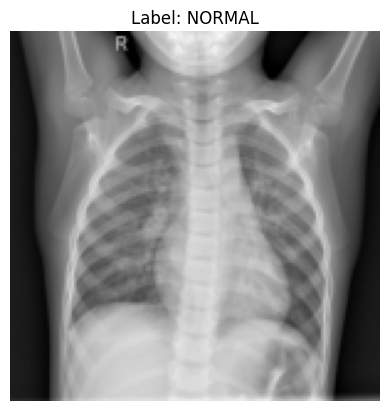

In [28]:
import matplotlib.pyplot as plt
import numpy as np


image, label = train_data[0]  


image_np = image.numpy().transpose((1, 2, 0))

mean = np.array([0.5])
std = np.array([0.5])
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1)

plt.imshow(image_np)
plt.title(f"Label: {train_data.classes[label]}")
plt.axis('off')
plt.show()


In [29]:
def get_model(model_name, num_classes=2):
    if model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Unknown model")
    
    return model


In [30]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = dataloaders['train']
            else:
                model.eval()
                dataloader = dataloaders['val']
            
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model


In [31]:
dataloaders = {'train': train_loader, 'val': val_loader}
models_to_train = ["vgg16", "resnet18", "efficientnet_b0"]
trained_models = {}

for model_name in models_to_train:
    print(f"\n--- Training {model_name.upper()} ---")
    model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    trained_model = train_model(model, criterion, optimizer, dataloaders, num_epochs=5)
    trained_models[model_name] = trained_model


--- Training VGG16 ---
Epoch 1/5
train Loss: 0.1515 Acc: 0.9438
val Loss: 1.6629 Acc: 0.6875
Epoch 2/5
train Loss: 0.0616 Acc: 0.9785
val Loss: 0.0480 Acc: 1.0000
Epoch 3/5
train Loss: 0.0427 Acc: 0.9850
val Loss: 0.1868 Acc: 0.9375
Epoch 4/5
train Loss: 0.0269 Acc: 0.9904
val Loss: 0.1133 Acc: 0.9375
Epoch 5/5
train Loss: 0.0258 Acc: 0.9906
val Loss: 0.0441 Acc: 1.0000
Best val Acc: 1.0000

--- Training RESNET18 ---
Epoch 1/5
train Loss: 0.0934 Acc: 0.9651
val Loss: 0.2662 Acc: 0.8750
Epoch 2/5
train Loss: 0.0264 Acc: 0.9910
val Loss: 0.1233 Acc: 0.9375
Epoch 3/5
train Loss: 0.0130 Acc: 0.9960
val Loss: 0.1649 Acc: 0.8750
Epoch 4/5
train Loss: 0.0070 Acc: 0.9983
val Loss: 0.0358 Acc: 1.0000
Epoch 5/5
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.0866 Acc: 1.0000
Best val Acc: 1.0000

--- Training EFFICIENTNET_B0 ---
Epoch 1/5
train Loss: 0.1829 Acc: 0.9375
val Loss: 0.2177 Acc: 0.9375
Epoch 2/5
train Loss: 0.0477 Acc: 0.9850
val Loss: 0.1668 Acc: 0.9375
Epoch 3/5
train Loss: 0.0321 Acc:

In [40]:
def evaluate(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

for name, model in trained_models.items():
    acc = evaluate(model, test_loader)
    print(f"{name.upper()} Test Accuracy: {acc:.4f}")


VGG16 Test Accuracy: 0.9151
RESNET18 Test Accuracy: 0.8253
EFFICIENTNET_B0 Test Accuracy: 0.8029
